<a href="https://colab.research.google.com/github/rybak97/free_courses/blob/main/Introduction_to_Graph_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on: https://www.datacamp.com/tutorial/comprehensive-introduction-graph-neural-networks-gnns-tutorial

In [29]:
import os
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.nn import GATConv
import numpy as np

In [17]:
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-l8oa8513
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-l8oa8513
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 94eae251a71a798a54a2b9fe631ef4e6fada9a84
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Planetoid is a citation network dataset from Cora, CiteSeer, and PubMed. The nodes are documents with 1433-dimensional bag-of-words feature vectors, and the edges are citation links between research papers. There are 7 classes, and we will train the model to predict missing labels.

In [18]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


We will create a GCN model structure that contains two GCNConv layers relu activation and a dropout.

In [19]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(43)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=12)
print(model)

GCN(
  (conv1): GCNConv(1433, 12)
  (conv2): GCNConv(12, 7)
)


Visualizing Untrained GCN network

In [20]:
def visualize(h, color, cmap=None):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure()
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=30, c=color, cmap=cmap)
    plt.show()

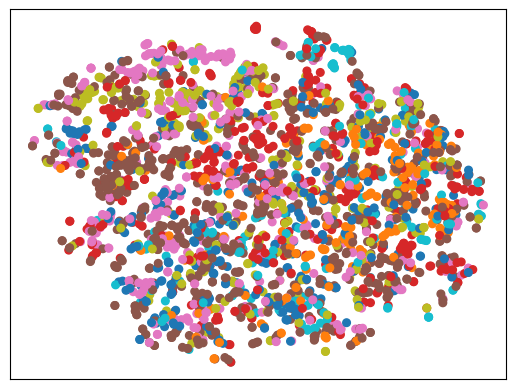

In [21]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y, cmap='tab10')

# Training GNN

We will train our model on 80 Epochs using Adam optimization and the Cross-Entropy Loss function.

In the train function, we have:

Clear the gradient, Performed a single forward pass, Compute loss using training nodes, Calculate gradient, and update the parameters

---


In the test function, we have:


Predicted node class, Extracted class label with the highest probability, Checked how many values have been predicted correctly, Creating accuracy ratio using a sum of correct predictions divided by a total number of nodes.

In [22]:
model = GCN(hidden_channels=12)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc


for epoch in range(1, 81):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')


Epoch: 001, Loss: 1.9460
Epoch: 002, Loss: 1.9417
Epoch: 003, Loss: 1.9362
Epoch: 004, Loss: 1.9289
Epoch: 005, Loss: 1.9232
Epoch: 006, Loss: 1.9150
Epoch: 007, Loss: 1.9075
Epoch: 008, Loss: 1.9003
Epoch: 009, Loss: 1.8922
Epoch: 010, Loss: 1.8836
Epoch: 011, Loss: 1.8685
Epoch: 012, Loss: 1.8629
Epoch: 013, Loss: 1.8568
Epoch: 014, Loss: 1.8386
Epoch: 015, Loss: 1.8254
Epoch: 016, Loss: 1.8147
Epoch: 017, Loss: 1.8019
Epoch: 018, Loss: 1.7917
Epoch: 019, Loss: 1.7700
Epoch: 020, Loss: 1.7595
Epoch: 021, Loss: 1.7545
Epoch: 022, Loss: 1.7363
Epoch: 023, Loss: 1.7207
Epoch: 024, Loss: 1.7051
Epoch: 025, Loss: 1.6910
Epoch: 026, Loss: 1.6667
Epoch: 027, Loss: 1.6623
Epoch: 028, Loss: 1.6448
Epoch: 029, Loss: 1.6270
Epoch: 030, Loss: 1.6127
Epoch: 031, Loss: 1.5828
Epoch: 032, Loss: 1.5721
Epoch: 033, Loss: 1.5578
Epoch: 034, Loss: 1.5434
Epoch: 035, Loss: 1.5025
Epoch: 036, Loss: 1.5110
Epoch: 037, Loss: 1.4664
Epoch: 038, Loss: 1.4739
Epoch: 039, Loss: 1.4544
Epoch: 040, Loss: 1.4095


In [23]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8040


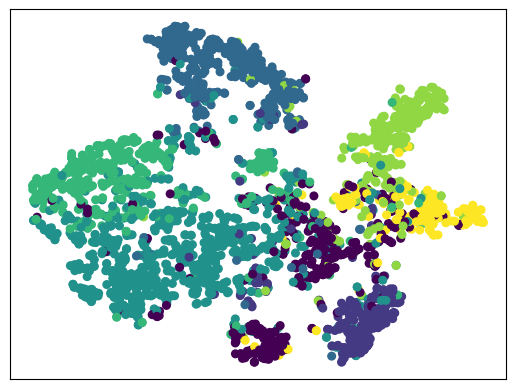

In [24]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

Training GATConv Model

In [26]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(43)
        self.conv1 = GATConv(dataset.num_features, hidden_channels,heads)
        self.conv2 = GATConv(heads*hidden_channels, dataset.num_classes,heads)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=12, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      correct = pred[mask] == data.y[mask]
      acc = int(correct.sum()) / int(mask.sum())
      return acc

val_acc_all = []
test_acc_all = []

for epoch in range(1, 81):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    val_acc_all.append(val_acc)
    test_acc_all.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 12, heads=8)
  (conv2): GATConv(96, 7, heads=8)
)
Epoch: 001, Loss: 4.0280, Val: 0.2400, Test: 0.2040
Epoch: 002, Loss: 3.9407, Val: 0.1940, Test: 0.1850
Epoch: 003, Loss: 3.8252, Val: 0.1740, Test: 0.1680
Epoch: 004, Loss: 3.6779, Val: 0.1700, Test: 0.1590
Epoch: 005, Loss: 3.4995, Val: 0.1560, Test: 0.1530
Epoch: 006, Loss: 3.2783, Val: 0.1400, Test: 0.1410
Epoch: 007, Loss: 3.0214, Val: 0.1300, Test: 0.1370
Epoch: 008, Loss: 2.7816, Val: 0.1220, Test: 0.1330
Epoch: 009, Loss: 2.4933, Val: 0.1160, Test: 0.1290
Epoch: 010, Loss: 2.2707, Val: 0.1160, Test: 0.1280
Epoch: 011, Loss: 2.1013, Val: 0.1260, Test: 0.1340
Epoch: 012, Loss: 1.9851, Val: 0.1640, Test: 0.1570
Epoch: 013, Loss: 1.9005, Val: 0.2300, Test: 0.2310
Epoch: 014, Loss: 1.8493, Val: 0.5000, Test: 0.5060
Epoch: 015, Loss: 1.7751, Val: 0.6940, Test: 0.6850
Epoch: 016, Loss: 1.7743, Val: 0.7180, Test: 0.7040
Epoch: 017, Loss: 1.7472, Val: 0.7400, Test: 0.7090
Epoch: 018, Loss: 1.7324, Val: 0.702

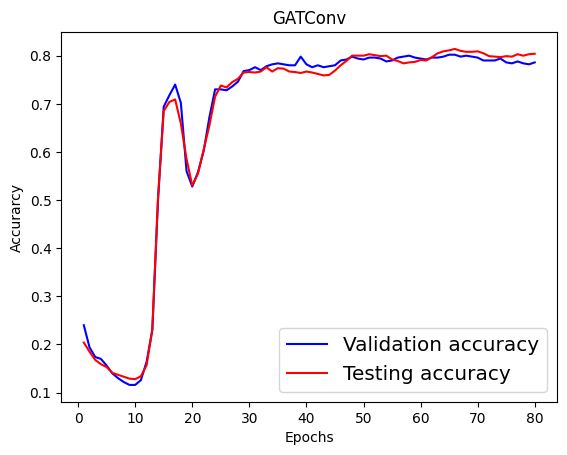

In [30]:
plt.plot(np.arange(1, len(val_acc_all) + 1), val_acc_all, label='Validation accuracy', c='blue')
plt.plot(np.arange(1, len(test_acc_all) + 1), test_acc_all, label='Testing accuracy', c='red')
plt.xlabel('Epochs')
plt.ylabel('Accurarcy')
plt.title('GATConv')
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('gat_loss.png')
plt.show()

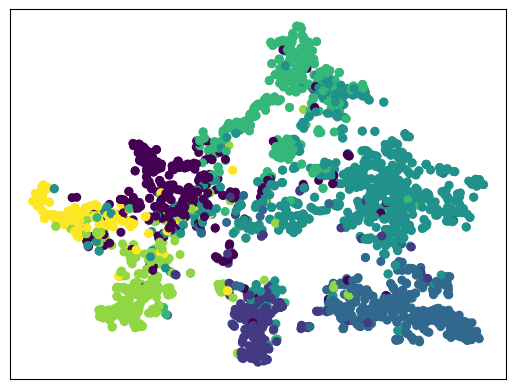

In [31]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)